# Test Domain-aware Model Implementation

## 1.Load Data

In [29]:
# Functions loading data from json file to dataframe
import json
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_json_data(domain1_train_file, domain2_train_file, test_data_file):
    def load_json_lines(file):
        with open(file, "r") as f:
            return [json.loads(line) for line in f if line.strip()]  # avoid empty line

    domain1_train_data = load_json_lines(domain1_train_file)
    domain2_train_data = load_json_lines(domain2_train_file)
    test_data = load_json_lines(test_data_file)

    return domain1_train_data, domain2_train_data, test_data



import pandas as pd

# Convert to dataframe from list
def convert_to_dataframe(domain1_train_data, domain2_train_data, test_data):

    df_train_domain1 = pd.DataFrame(domain1_train_data)

    df_train_domain2 = pd.DataFrame(domain2_train_data)

    df_test = pd.DataFrame(test_data)

    return df_train_domain1, df_train_domain2, df_test


# # Load data from json file to dataframe
domain1_train_file = "domain1_train_data.json"
domain2_train_file = "domain2_train_data.json"
test_data_file = "test_data.json"

# from google.colab import files
# files.upload()

domain1_train_data, domain2_train_data, test_data = load_json_data(domain1_train_file, domain2_train_file, test_data_file)
df_train_domain1, df_train_domain2, df_test = convert_to_dataframe(domain1_train_data, domain2_train_data, test_data)

## 2.Process Data

In [24]:
# Add domain column to two datasets
df_train_domain1['domain'] = 0  # 0 -> domain 1
df_train_domain2['domain'] = 1  # 1 -> domain 2

df_train_domain1.head()

,text,label,id,domain
0,"[6, 22, 34, 76, 501, 977, 1, 2514, 13623, 76, ...",0,0,0
1,"[222, 31, 4108, 104, 132, 361, 39, 2305, 12, 9...",0,1,0
2,"[736, 7194, 113, 12, 366, 2870, 123, 101, 12, ...",0,2,0
3,"[48, 1, 2025, 69, 361, 533, 327, 237, 4150, 13...",0,3,0
4,"[2973, 66, 1, 1493, 260, 2740, 50, 1027, 50, 1...",0,4,0


In [25]:
from sklearn.model_selection import train_test_split

# merge 2 domains
df_full_train = pd.concat([df_train_domain1, df_train_domain2], ignore_index=True)

# train dev split
df_train, df_dev = train_test_split(df_full_train, test_size=0.2, stratify=df_full_train['label'], random_state=42)
df_test['domain'] = -1  # test doesn't count into domain loss


## 3.Model Define

In [13]:
# Dataset Class
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

# include_domain=True means to include domain label
class DomainAwareDataset(Dataset):
    def __init__(self, df, max_len=512, pad_token=0, include_label=True, include_domain=True):
        self.include_label = include_label
        self.include_domain = include_domain
        self.max_len = max_len
        self.pad_token = pad_token
        self.texts = [self._pad_or_truncate(seq) for seq in df['text']]
        if include_label:
            self.labels = df['label'].tolist()
        if include_domain:
            self.domains = df['domain'].tolist()

    def _pad_or_truncate(self, seq):
        return seq + [self.pad_token] * (self.max_len - len(seq)) if len(seq) < self.max_len else seq[:self.max_len]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {'input': torch.tensor(self.texts[idx], dtype=torch.long)}
        if self.include_label:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.float)
        if self.include_domain:
            item['domain'] = torch.tensor(self.domains[idx], dtype=torch.float)
        return item


# Transformer Model with Multi-task Heads
import torch.nn as nn

class DomainAwareTransformer(nn.Module):
    def __init__(self, vocab_size=17120, emb_dim=128, n_heads=4, n_layers=2, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_encoding = self._positional_encoding(max_len, emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.shared_proj = nn.Linear(emb_dim, emb_dim)
        self.main_head = nn.Linear(emb_dim, 1)
        self.domain_head = nn.Linear(emb_dim, 1)

    def _positional_encoding(self, max_len, d_model):
        pos = torch.arange(0, max_len).unsqueeze(1)
        i = torch.arange(0, d_model, 2)
        angle_rates = 1 / torch.pow(10000, (i.float() / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos * angle_rates)
        pe[:, 1::2] = torch.cos(pos * angle_rates)
        return pe.unsqueeze(0)

    def forward(self, x):
        mask = (x == 0)
        emb = self.embedding(x) + self.pos_encoding[:, :x.size(1)].to(x.device)
        out = self.transformer(emb, src_key_padding_mask=mask)
        pooled = out.mean(dim=1)
        rep = self.shared_proj(pooled)
        main_out = self.main_head(rep).squeeze(-1)
        domain_out = torch.sigmoid(self.domain_head(rep)).squeeze(-1)
        return main_out, domain_out


# Transformer Model with Multi-task Heads
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataset, batch_size=32):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            targets = batch['label'].to(device)
            main_out, _ = model(inputs)
            probs = torch.sigmoid(main_out)
            preds.extend((probs > 0.5).long().cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return accuracy_score(labels, preds), f1_score(labels, preds)

import matplotlib.pyplot as plt
import pandas as pd
import os

def train_and_log(model, dataset, dev_dataset=None, epochs=10, lr=1e-4,
                  batch_size=32, domain_loss_weight=0.3, pos_weight_val=1.0,
                  run_id=1, save_dir="logs", verbose=True, patience=3):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_main_fn = BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val]).to(device))
    loss_domain_fn = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    log = {"epoch": [], "main_loss": [], "dev_acc": [], "dev_f1": []}

    best_f1 = 0
    no_improve_count = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_main_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            domains = batch.get('domain', None)
            if domains is not None:
                domains = domains.to(device)

            optimizer.zero_grad()
            main_out, domain_out = model(inputs)
            loss_main = loss_main_fn(main_out, labels)
            if domain_loss_weight > 0 and domains is not None:
                loss_domain = loss_domain_fn(domain_out, domains)
                loss = loss_main + domain_loss_weight * loss_domain
            else:
                loss = loss_main

            loss.backward()
            optimizer.step()
            total_main_loss += loss_main.item()

        # Dev evaluation
        dev_acc, dev_f1 = 0, 0
        if dev_dataset:
            dev_acc, dev_f1 = evaluate(model, dev_dataset)

        log["epoch"].append(epoch + 1)
        log["main_loss"].append(total_main_loss)
        log["dev_acc"].append(dev_acc)
        log["dev_f1"].append(dev_f1)

        if verbose:
            print(f"[Run {run_id}] Epoch {epoch+1}: Loss={total_main_loss:.4f}, Dev Acc={dev_acc:.4f}, F1={dev_f1:.4f}")

        # Early stopping check
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            no_improve_count = 0
            best_model_state = model.state_dict()
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Save log
    log_df = pd.DataFrame(log)
    log_path = os.path.join(save_dir, f"log_run{run_id}_lambda{domain_loss_weight}.csv")
    log_df.to_csv(log_path, index=False)

    # Plot loss
    plt.figure()
    plt.plot(log["epoch"], log["main_loss"], label="Main Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (λ={domain_loss_weight}, Run {run_id})")
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"loss_plot_run{run_id}_lambda{domain_loss_weight}.png"))
    plt.close()

    return model, log_df



def predict(model, dataset, batch_size=32, threshold=0.5):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            main_out, _ = model(inputs)
            probs = torch.sigmoid(main_out)
            preds = (probs > threshold).long().cpu().numpy()
            predictions.extend(preds)
    return predictions

In [15]:
from statistics import mean, stdev

def run_experiments(domain_weights=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80], num_runs=3):
    summary = []

    for lambda_val in domain_weights:
        all_acc, all_f1 = [], []
        for run in range(1, num_runs + 1):
            print(f"\n>>> Lambda={lambda_val}, Run={run}")
            model = DomainAwareTransformer()
            trained_model, log_df = train_and_log(
                model, train_dataset, dev_dataset=dev_dataset,
                domain_loss_weight=lambda_val, run_id=run
            )
            all_acc.append(log_df["dev_acc"].iloc[-1])
            all_f1.append(log_df["dev_f1"].iloc[-1])

        summary.append({
            "lambda": lambda_val,
            "mean_acc": mean(all_acc),
            "std_acc": stdev(all_acc),
            "mean_f1": mean(all_f1),
            "std_f1": stdev(all_f1),
        })

    # save
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv("logs/experiment_summary.csv", index=False)
    print("\n>>> Summary saved to logs/experiment_summary.csv")
    return summary_df

In [17]:
train_dataset = DomainAwareDataset(df_train)
dev_dataset = DomainAwareDataset(df_dev)
test_dataset = DomainAwareDataset(df_test, include_label=False, include_domain=False)

summary = run_experiments(domain_weights=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80], num_runs=3)


>>> Lambda=0.0, Run=1


[Run 1] Epoch 1: Loss=56.6466, Dev Acc=0.8767, F1=0.9340


[Run 1] Epoch 2: Loss=37.8036, Dev Acc=0.9350, F1=0.9632


[Run 1] Epoch 3: Loss=26.7568, Dev Acc=0.9300, F1=0.9597


[Run 1] Epoch 4: Loss=22.1100, Dev Acc=0.9417, F1=0.9669


[Run 1] Epoch 5: Loss=18.2869, Dev Acc=0.9442, F1=0.9682


[Run 1] Epoch 6: Loss=14.1397, Dev Acc=0.9350, F1=0.9638


[Run 1] Epoch 7: Loss=11.7665, Dev Acc=0.9467, F1=0.9697


[Run 1] Epoch 8: Loss=9.4097, Dev Acc=0.9450, F1=0.9687


[Run 1] Epoch 9: Loss=6.5659, Dev Acc=0.9425, F1=0.9671


[Run 1] Epoch 10: Loss=5.4617, Dev Acc=0.9525, F1=0.9730

>>> Lambda=0.0, Run=2


[Run 2] Epoch 1: Loss=56.7887, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=38.7408, Dev Acc=0.9342, F1=0.9635


[Run 2] Epoch 3: Loss=24.5595, Dev Acc=0.9217, F1=0.9572


[Run 2] Epoch 4: Loss=19.2057, Dev Acc=0.9383, F1=0.9653


[Run 2] Epoch 5: Loss=14.7168, Dev Acc=0.9417, F1=0.9673


[Run 2] Epoch 6: Loss=12.8170, Dev Acc=0.9275, F1=0.9602


[Run 2] Epoch 7: Loss=10.5322, Dev Acc=0.9392, F1=0.9663


[Run 2] Epoch 8: Loss=7.2188, Dev Acc=0.9408, F1=0.9670
Early stopping triggered at epoch 8

>>> Lambda=0.0, Run=3


[Run 3] Epoch 1: Loss=56.2619, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=35.3248, Dev Acc=0.9200, F1=0.9557


[Run 3] Epoch 3: Loss=23.8605, Dev Acc=0.9192, F1=0.9555


[Run 3] Epoch 4: Loss=19.2595, Dev Acc=0.9333, F1=0.9624


[Run 3] Epoch 5: Loss=16.0648, Dev Acc=0.9133, F1=0.9527


[Run 3] Epoch 6: Loss=11.7935, Dev Acc=0.9342, F1=0.9634


[Run 3] Epoch 7: Loss=8.9895, Dev Acc=0.9333, F1=0.9632


[Run 3] Epoch 8: Loss=7.6464, Dev Acc=0.9292, F1=0.9610


[Run 3] Epoch 9: Loss=6.1453, Dev Acc=0.9367, F1=0.9647


[Run 3] Epoch 10: Loss=3.8715, Dev Acc=0.9383, F1=0.9657

>>> Lambda=0.05, Run=1


[Run 1] Epoch 1: Loss=55.4867, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=36.2485, Dev Acc=0.8900, F1=0.9408


[Run 1] Epoch 3: Loss=26.6437, Dev Acc=0.9250, F1=0.9586


[Run 1] Epoch 4: Loss=20.3828, Dev Acc=0.9067, F1=0.9494


[Run 1] Epoch 5: Loss=16.4830, Dev Acc=0.9125, F1=0.9523


[Run 1] Epoch 6: Loss=12.9512, Dev Acc=0.9292, F1=0.9611


[Run 1] Epoch 7: Loss=10.7901, Dev Acc=0.9283, F1=0.9606


[Run 1] Epoch 8: Loss=7.7954, Dev Acc=0.9208, F1=0.9567


[Run 1] Epoch 9: Loss=6.7562, Dev Acc=0.9142, F1=0.9532
Early stopping triggered at epoch 9

>>> Lambda=0.05, Run=2


[Run 2] Epoch 1: Loss=56.1792, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=39.7021, Dev Acc=0.9125, F1=0.9521


[Run 2] Epoch 3: Loss=25.3045, Dev Acc=0.9258, F1=0.9587


[Run 2] Epoch 4: Loss=20.6602, Dev Acc=0.9067, F1=0.9494


[Run 2] Epoch 5: Loss=16.3258, Dev Acc=0.9300, F1=0.9613


[Run 2] Epoch 6: Loss=13.9557, Dev Acc=0.9233, F1=0.9579


[Run 2] Epoch 7: Loss=10.4927, Dev Acc=0.9392, F1=0.9662


[Run 2] Epoch 8: Loss=8.1607, Dev Acc=0.9267, F1=0.9597


[Run 2] Epoch 9: Loss=6.0747, Dev Acc=0.9342, F1=0.9637


[Run 2] Epoch 10: Loss=4.3318, Dev Acc=0.9350, F1=0.9642
Early stopping triggered at epoch 10

>>> Lambda=0.05, Run=3


[Run 3] Epoch 1: Loss=56.4124, Dev Acc=0.8792, F1=0.9349


[Run 3] Epoch 2: Loss=38.7842, Dev Acc=0.9308, F1=0.9613


[Run 3] Epoch 3: Loss=27.3453, Dev Acc=0.9192, F1=0.9556


[Run 3] Epoch 4: Loss=21.3001, Dev Acc=0.9225, F1=0.9575


[Run 3] Epoch 5: Loss=17.7824, Dev Acc=0.9092, F1=0.9507
Early stopping triggered at epoch 5

>>> Lambda=0.1, Run=1


[Run 1] Epoch 1: Loss=56.9999, Dev Acc=0.8567, F1=0.9224


[Run 1] Epoch 2: Loss=37.6534, Dev Acc=0.9158, F1=0.9536


[Run 1] Epoch 3: Loss=25.8496, Dev Acc=0.9067, F1=0.9494


[Run 1] Epoch 4: Loss=19.9150, Dev Acc=0.9300, F1=0.9612


[Run 1] Epoch 5: Loss=16.7200, Dev Acc=0.9325, F1=0.9624


[Run 1] Epoch 6: Loss=12.8064, Dev Acc=0.9392, F1=0.9660


[Run 1] Epoch 7: Loss=9.5846, Dev Acc=0.9258, F1=0.9592


[Run 1] Epoch 8: Loss=6.5240, Dev Acc=0.9408, F1=0.9670


[Run 1] Epoch 9: Loss=4.0219, Dev Acc=0.9300, F1=0.9614


[Run 1] Epoch 10: Loss=3.7484, Dev Acc=0.9383, F1=0.9657

>>> Lambda=0.1, Run=2


[Run 2] Epoch 1: Loss=56.8527, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=45.0934, Dev Acc=0.9200, F1=0.9547


[Run 2] Epoch 3: Loss=30.7010, Dev Acc=0.9225, F1=0.9572


[Run 2] Epoch 4: Loss=22.6712, Dev Acc=0.9142, F1=0.9528


[Run 2] Epoch 5: Loss=18.1029, Dev Acc=0.9267, F1=0.9593


[Run 2] Epoch 6: Loss=14.0688, Dev Acc=0.9258, F1=0.9590


[Run 2] Epoch 7: Loss=10.9172, Dev Acc=0.9150, F1=0.9536


[Run 2] Epoch 8: Loss=8.9801, Dev Acc=0.9233, F1=0.9578
Early stopping triggered at epoch 8

>>> Lambda=0.1, Run=3


[Run 3] Epoch 1: Loss=55.5435, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=35.5877, Dev Acc=0.9258, F1=0.9588


[Run 3] Epoch 3: Loss=25.3036, Dev Acc=0.9325, F1=0.9613


[Run 3] Epoch 4: Loss=20.7419, Dev Acc=0.9092, F1=0.9463


[Run 3] Epoch 5: Loss=17.7055, Dev Acc=0.8500, F1=0.9072


[Run 3] Epoch 6: Loss=13.6791, Dev Acc=0.9300, F1=0.9595
Early stopping triggered at epoch 6

>>> Lambda=0.15, Run=1


[Run 1] Epoch 1: Loss=55.9741, Dev Acc=0.8608, F1=0.9238


[Run 1] Epoch 2: Loss=35.2395, Dev Acc=0.9233, F1=0.9574


[Run 1] Epoch 3: Loss=24.4051, Dev Acc=0.9308, F1=0.9614


[Run 1] Epoch 4: Loss=19.5679, Dev Acc=0.9350, F1=0.9631


[Run 1] Epoch 5: Loss=15.3527, Dev Acc=0.9325, F1=0.9621


[Run 1] Epoch 6: Loss=13.0897, Dev Acc=0.9433, F1=0.9678


[Run 1] Epoch 7: Loss=8.9999, Dev Acc=0.9425, F1=0.9677


[Run 1] Epoch 8: Loss=7.0189, Dev Acc=0.9442, F1=0.9685


[Run 1] Epoch 9: Loss=5.3723, Dev Acc=0.9367, F1=0.9648


[Run 1] Epoch 10: Loss=4.2486, Dev Acc=0.9425, F1=0.9670

>>> Lambda=0.15, Run=2


[Run 2] Epoch 1: Loss=56.1474, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=35.9991, Dev Acc=0.9283, F1=0.9592


[Run 2] Epoch 3: Loss=25.4333, Dev Acc=0.9333, F1=0.9629


[Run 2] Epoch 4: Loss=20.5223, Dev Acc=0.9250, F1=0.9588


[Run 2] Epoch 5: Loss=15.8623, Dev Acc=0.9408, F1=0.9671


[Run 2] Epoch 6: Loss=11.9378, Dev Acc=0.9425, F1=0.9679


[Run 2] Epoch 7: Loss=10.6444, Dev Acc=0.9425, F1=0.9672


[Run 2] Epoch 8: Loss=7.2810, Dev Acc=0.9483, F1=0.9712


[Run 2] Epoch 9: Loss=5.1520, Dev Acc=0.9467, F1=0.9702


[Run 2] Epoch 10: Loss=3.8808, Dev Acc=0.9425, F1=0.9680

>>> Lambda=0.15, Run=3


[Run 3] Epoch 1: Loss=56.9071, Dev Acc=0.8583, F1=0.9222


[Run 3] Epoch 2: Loss=43.5644, Dev Acc=0.9025, F1=0.9469


[Run 3] Epoch 3: Loss=25.1377, Dev Acc=0.9283, F1=0.9602


[Run 3] Epoch 4: Loss=17.8858, Dev Acc=0.9158, F1=0.9539


[Run 3] Epoch 5: Loss=14.1026, Dev Acc=0.9200, F1=0.9562


[Run 3] Epoch 6: Loss=10.5920, Dev Acc=0.9367, F1=0.9649


[Run 3] Epoch 7: Loss=8.3889, Dev Acc=0.9150, F1=0.9536


[Run 3] Epoch 8: Loss=6.0996, Dev Acc=0.9433, F1=0.9684


[Run 3] Epoch 9: Loss=5.5939, Dev Acc=0.9325, F1=0.9628


[Run 3] Epoch 10: Loss=3.9477, Dev Acc=0.9400, F1=0.9666

>>> Lambda=0.2, Run=1


[Run 1] Epoch 1: Loss=55.7219, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=37.9241, Dev Acc=0.8950, F1=0.9434


[Run 1] Epoch 3: Loss=25.5604, Dev Acc=0.8992, F1=0.9455


[Run 1] Epoch 4: Loss=19.0842, Dev Acc=0.9208, F1=0.9564


[Run 1] Epoch 5: Loss=16.0827, Dev Acc=0.9200, F1=0.9558


[Run 1] Epoch 6: Loss=13.3481, Dev Acc=0.9242, F1=0.9583


[Run 1] Epoch 7: Loss=9.8964, Dev Acc=0.9208, F1=0.9565


[Run 1] Epoch 8: Loss=6.9135, Dev Acc=0.9417, F1=0.9675


[Run 1] Epoch 9: Loss=5.6988, Dev Acc=0.9500, F1=0.9719


[Run 1] Epoch 10: Loss=4.3090, Dev Acc=0.9525, F1=0.9732

>>> Lambda=0.2, Run=2


[Run 2] Epoch 1: Loss=56.3251, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=39.8288, Dev Acc=0.9017, F1=0.9467


[Run 2] Epoch 3: Loss=25.8218, Dev Acc=0.9267, F1=0.9592


[Run 2] Epoch 4: Loss=19.8422, Dev Acc=0.9300, F1=0.9611


[Run 2] Epoch 5: Loss=15.4212, Dev Acc=0.9033, F1=0.9477


[Run 2] Epoch 6: Loss=13.4633, Dev Acc=0.9200, F1=0.9561


[Run 2] Epoch 7: Loss=9.4103, Dev Acc=0.9292, F1=0.9610
Early stopping triggered at epoch 7

>>> Lambda=0.2, Run=3


[Run 3] Epoch 1: Loss=57.3528, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=45.1468, Dev Acc=0.9008, F1=0.9418


[Run 3] Epoch 3: Loss=28.2739, Dev Acc=0.9225, F1=0.9554


[Run 3] Epoch 4: Loss=22.7758, Dev Acc=0.9267, F1=0.9579


[Run 3] Epoch 5: Loss=18.9711, Dev Acc=0.9408, F1=0.9665


[Run 3] Epoch 6: Loss=12.9420, Dev Acc=0.9292, F1=0.9589


[Run 3] Epoch 7: Loss=10.1573, Dev Acc=0.9292, F1=0.9586


[Run 3] Epoch 8: Loss=7.0529, Dev Acc=0.9442, F1=0.9684


[Run 3] Epoch 9: Loss=4.0865, Dev Acc=0.9483, F1=0.9709


[Run 3] Epoch 10: Loss=3.8135, Dev Acc=0.9383, F1=0.9644

>>> Lambda=0.25, Run=1


[Run 1] Epoch 1: Loss=56.9329, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=40.4821, Dev Acc=0.9308, F1=0.9612


[Run 1] Epoch 3: Loss=26.4216, Dev Acc=0.9383, F1=0.9656


[Run 1] Epoch 4: Loss=22.1413, Dev Acc=0.9375, F1=0.9647


[Run 1] Epoch 5: Loss=17.7852, Dev Acc=0.9458, F1=0.9693


[Run 1] Epoch 6: Loss=13.5892, Dev Acc=0.9508, F1=0.9722


[Run 1] Epoch 7: Loss=9.9916, Dev Acc=0.9383, F1=0.9657


[Run 1] Epoch 8: Loss=7.0621, Dev Acc=0.9500, F1=0.9719


[Run 1] Epoch 9: Loss=4.9827, Dev Acc=0.9517, F1=0.9729


[Run 1] Epoch 10: Loss=3.6959, Dev Acc=0.9467, F1=0.9696

>>> Lambda=0.25, Run=2


[Run 2] Epoch 1: Loss=57.3709, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=44.0646, Dev Acc=0.9158, F1=0.9532


[Run 2] Epoch 3: Loss=25.6298, Dev Acc=0.9317, F1=0.9618


[Run 2] Epoch 4: Loss=20.5054, Dev Acc=0.9292, F1=0.9607


[Run 2] Epoch 5: Loss=18.0502, Dev Acc=0.9383, F1=0.9657


[Run 2] Epoch 6: Loss=12.9604, Dev Acc=0.9383, F1=0.9656


[Run 2] Epoch 7: Loss=10.3765, Dev Acc=0.9392, F1=0.9657


[Run 2] Epoch 8: Loss=8.4300, Dev Acc=0.9483, F1=0.9709


[Run 2] Epoch 9: Loss=6.7724, Dev Acc=0.9475, F1=0.9706


[Run 2] Epoch 10: Loss=4.7822, Dev Acc=0.9433, F1=0.9684

>>> Lambda=0.25, Run=3


[Run 3] Epoch 1: Loss=56.5931, Dev Acc=0.8742, F1=0.9329


[Run 3] Epoch 2: Loss=39.4241, Dev Acc=0.9317, F1=0.9613


[Run 3] Epoch 3: Loss=25.7171, Dev Acc=0.9358, F1=0.9641


[Run 3] Epoch 4: Loss=19.4953, Dev Acc=0.9450, F1=0.9688


[Run 3] Epoch 5: Loss=14.9825, Dev Acc=0.9358, F1=0.9642


[Run 3] Epoch 6: Loss=11.8375, Dev Acc=0.9283, F1=0.9603


[Run 3] Epoch 7: Loss=8.1921, Dev Acc=0.9458, F1=0.9696


[Run 3] Epoch 8: Loss=4.8302, Dev Acc=0.9225, F1=0.9547


[Run 3] Epoch 9: Loss=5.5815, Dev Acc=0.9517, F1=0.9727


[Run 3] Epoch 10: Loss=2.6808, Dev Acc=0.9400, F1=0.9664

>>> Lambda=0.3, Run=1


[Run 1] Epoch 1: Loss=57.0537, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=47.6113, Dev Acc=0.9042, F1=0.9480


[Run 1] Epoch 3: Loss=30.3545, Dev Acc=0.9192, F1=0.9557


[Run 1] Epoch 4: Loss=23.4659, Dev Acc=0.9133, F1=0.9527


[Run 1] Epoch 5: Loss=18.5886, Dev Acc=0.9208, F1=0.9566


[Run 1] Epoch 6: Loss=14.7142, Dev Acc=0.9317, F1=0.9622


[Run 1] Epoch 7: Loss=12.0653, Dev Acc=0.9375, F1=0.9653


[Run 1] Epoch 8: Loss=9.6263, Dev Acc=0.9325, F1=0.9628


[Run 1] Epoch 9: Loss=7.1202, Dev Acc=0.9250, F1=0.9588


[Run 1] Epoch 10: Loss=5.4515, Dev Acc=0.9475, F1=0.9703

>>> Lambda=0.3, Run=2


[Run 2] Epoch 1: Loss=55.6418, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=36.9200, Dev Acc=0.9208, F1=0.9557


[Run 2] Epoch 3: Loss=26.6682, Dev Acc=0.9067, F1=0.9490


[Run 2] Epoch 4: Loss=21.6333, Dev Acc=0.9283, F1=0.9599


[Run 2] Epoch 5: Loss=17.6830, Dev Acc=0.9358, F1=0.9642


[Run 2] Epoch 6: Loss=15.3359, Dev Acc=0.9267, F1=0.9596


[Run 2] Epoch 7: Loss=10.7939, Dev Acc=0.9425, F1=0.9679


[Run 2] Epoch 8: Loss=9.2569, Dev Acc=0.9425, F1=0.9678


[Run 2] Epoch 9: Loss=7.4836, Dev Acc=0.9383, F1=0.9656


[Run 2] Epoch 10: Loss=5.1304, Dev Acc=0.9400, F1=0.9665
Early stopping triggered at epoch 10

>>> Lambda=0.3, Run=3


[Run 3] Epoch 1: Loss=57.2205, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=42.0774, Dev Acc=0.9250, F1=0.9581


[Run 3] Epoch 3: Loss=25.7669, Dev Acc=0.9367, F1=0.9646


[Run 3] Epoch 4: Loss=21.3099, Dev Acc=0.9417, F1=0.9665


[Run 3] Epoch 5: Loss=16.8448, Dev Acc=0.9342, F1=0.9636


[Run 3] Epoch 6: Loss=13.7784, Dev Acc=0.9475, F1=0.9704


[Run 3] Epoch 7: Loss=9.4075, Dev Acc=0.9433, F1=0.9685


[Run 3] Epoch 8: Loss=7.3571, Dev Acc=0.9450, F1=0.9694


[Run 3] Epoch 9: Loss=6.6486, Dev Acc=0.9417, F1=0.9674
Early stopping triggered at epoch 9

>>> Lambda=0.35, Run=1


[Run 1] Epoch 1: Loss=56.8971, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=40.0558, Dev Acc=0.9342, F1=0.9632


[Run 1] Epoch 3: Loss=25.8319, Dev Acc=0.9367, F1=0.9647


[Run 1] Epoch 4: Loss=19.1516, Dev Acc=0.9308, F1=0.9616


[Run 1] Epoch 5: Loss=17.7539, Dev Acc=0.9358, F1=0.9642


[Run 1] Epoch 6: Loss=11.7714, Dev Acc=0.9392, F1=0.9661


[Run 1] Epoch 7: Loss=8.9664, Dev Acc=0.9442, F1=0.9687


[Run 1] Epoch 8: Loss=6.7644, Dev Acc=0.9267, F1=0.9596


[Run 1] Epoch 9: Loss=5.1752, Dev Acc=0.9467, F1=0.9700


[Run 1] Epoch 10: Loss=3.3585, Dev Acc=0.9250, F1=0.9588

>>> Lambda=0.35, Run=2


[Run 2] Epoch 1: Loss=56.0672, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=39.7652, Dev Acc=0.9258, F1=0.9579


[Run 2] Epoch 3: Loss=25.7716, Dev Acc=0.9108, F1=0.9479


[Run 2] Epoch 4: Loss=20.9343, Dev Acc=0.9375, F1=0.9642


[Run 2] Epoch 5: Loss=17.5448, Dev Acc=0.9258, F1=0.9569


[Run 2] Epoch 6: Loss=13.5484, Dev Acc=0.9392, F1=0.9659


[Run 2] Epoch 7: Loss=11.5349, Dev Acc=0.9450, F1=0.9688


[Run 2] Epoch 8: Loss=8.4556, Dev Acc=0.9425, F1=0.9674


[Run 2] Epoch 9: Loss=6.2402, Dev Acc=0.9492, F1=0.9712


[Run 2] Epoch 10: Loss=4.6924, Dev Acc=0.9475, F1=0.9702

>>> Lambda=0.35, Run=3


[Run 3] Epoch 1: Loss=56.5389, Dev Acc=0.8817, F1=0.9362


[Run 3] Epoch 2: Loss=35.8767, Dev Acc=0.9350, F1=0.9634


[Run 3] Epoch 3: Loss=25.3296, Dev Acc=0.9342, F1=0.9630


[Run 3] Epoch 4: Loss=19.7827, Dev Acc=0.9292, F1=0.9590


[Run 3] Epoch 5: Loss=16.3128, Dev Acc=0.9467, F1=0.9699


[Run 3] Epoch 6: Loss=12.6825, Dev Acc=0.9442, F1=0.9681


[Run 3] Epoch 7: Loss=9.2611, Dev Acc=0.9517, F1=0.9726


[Run 3] Epoch 8: Loss=6.7643, Dev Acc=0.9483, F1=0.9711


[Run 3] Epoch 9: Loss=5.1770, Dev Acc=0.9458, F1=0.9697


[Run 3] Epoch 10: Loss=5.9322, Dev Acc=0.9517, F1=0.9725
Early stopping triggered at epoch 10

>>> Lambda=0.4, Run=1


[Run 1] Epoch 1: Loss=56.4604, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=40.2092, Dev Acc=0.8975, F1=0.9442


[Run 1] Epoch 3: Loss=26.3066, Dev Acc=0.9175, F1=0.9547


[Run 1] Epoch 4: Loss=22.2088, Dev Acc=0.9008, F1=0.9464


[Run 1] Epoch 5: Loss=16.7412, Dev Acc=0.9192, F1=0.9558


[Run 1] Epoch 6: Loss=14.5201, Dev Acc=0.9283, F1=0.9605


[Run 1] Epoch 7: Loss=10.4605, Dev Acc=0.9142, F1=0.9532


[Run 1] Epoch 8: Loss=8.3324, Dev Acc=0.9308, F1=0.9619


[Run 1] Epoch 9: Loss=6.4934, Dev Acc=0.9225, F1=0.9576


[Run 1] Epoch 10: Loss=4.5814, Dev Acc=0.9333, F1=0.9632

>>> Lambda=0.4, Run=2


[Run 2] Epoch 1: Loss=56.8065, Dev Acc=0.8617, F1=0.9245


[Run 2] Epoch 2: Loss=40.0450, Dev Acc=0.9308, F1=0.9613


[Run 2] Epoch 3: Loss=26.7688, Dev Acc=0.9367, F1=0.9645


[Run 2] Epoch 4: Loss=22.5710, Dev Acc=0.9233, F1=0.9578


[Run 2] Epoch 5: Loss=17.3781, Dev Acc=0.9400, F1=0.9664


[Run 2] Epoch 6: Loss=13.7542, Dev Acc=0.9367, F1=0.9646


[Run 2] Epoch 7: Loss=10.8495, Dev Acc=0.9433, F1=0.9680


[Run 2] Epoch 8: Loss=7.9242, Dev Acc=0.9383, F1=0.9654


[Run 2] Epoch 9: Loss=6.1930, Dev Acc=0.9308, F1=0.9617


[Run 2] Epoch 10: Loss=5.1712, Dev Acc=0.9325, F1=0.9625
Early stopping triggered at epoch 10

>>> Lambda=0.4, Run=3


[Run 3] Epoch 1: Loss=56.8436, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=37.3420, Dev Acc=0.8608, F1=0.9154


[Run 3] Epoch 3: Loss=26.4750, Dev Acc=0.9292, F1=0.9601


[Run 3] Epoch 4: Loss=21.2775, Dev Acc=0.9283, F1=0.9592


[Run 3] Epoch 5: Loss=17.6442, Dev Acc=0.9425, F1=0.9677


[Run 3] Epoch 6: Loss=14.4396, Dev Acc=0.9425, F1=0.9681


[Run 3] Epoch 7: Loss=11.6470, Dev Acc=0.9525, F1=0.9732


[Run 3] Epoch 8: Loss=9.5428, Dev Acc=0.9333, F1=0.9631


[Run 3] Epoch 9: Loss=6.9752, Dev Acc=0.9458, F1=0.9697


[Run 3] Epoch 10: Loss=4.7997, Dev Acc=0.9467, F1=0.9701
Early stopping triggered at epoch 10

>>> Lambda=0.45, Run=1


[Run 1] Epoch 1: Loss=56.3438, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=38.2962, Dev Acc=0.9050, F1=0.9484


[Run 1] Epoch 3: Loss=25.9635, Dev Acc=0.9192, F1=0.9556


[Run 1] Epoch 4: Loss=22.6246, Dev Acc=0.9200, F1=0.9560


[Run 1] Epoch 5: Loss=17.3593, Dev Acc=0.9125, F1=0.9524


[Run 1] Epoch 6: Loss=12.8762, Dev Acc=0.9200, F1=0.9563


[Run 1] Epoch 7: Loss=11.0916, Dev Acc=0.9175, F1=0.9549


[Run 1] Epoch 8: Loss=8.0912, Dev Acc=0.9300, F1=0.9614


[Run 1] Epoch 9: Loss=5.7425, Dev Acc=0.9175, F1=0.9550


[Run 1] Epoch 10: Loss=5.5491, Dev Acc=0.9067, F1=0.9494

>>> Lambda=0.45, Run=2


[Run 2] Epoch 1: Loss=57.9008, Dev Acc=0.8575, F1=0.9229


[Run 2] Epoch 2: Loss=42.2425, Dev Acc=0.8975, F1=0.9395


[Run 2] Epoch 3: Loss=25.0657, Dev Acc=0.9417, F1=0.9668


[Run 2] Epoch 4: Loss=20.5811, Dev Acc=0.9408, F1=0.9665


[Run 2] Epoch 5: Loss=17.4077, Dev Acc=0.9467, F1=0.9697


[Run 2] Epoch 6: Loss=12.1359, Dev Acc=0.9458, F1=0.9691


[Run 2] Epoch 7: Loss=8.4255, Dev Acc=0.9467, F1=0.9698


[Run 2] Epoch 8: Loss=5.8427, Dev Acc=0.9483, F1=0.9708


[Run 2] Epoch 9: Loss=4.6997, Dev Acc=0.9467, F1=0.9698


[Run 2] Epoch 10: Loss=3.2234, Dev Acc=0.9458, F1=0.9694

>>> Lambda=0.45, Run=3


[Run 3] Epoch 1: Loss=56.7687, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=41.1142, Dev Acc=0.9025, F1=0.9467


[Run 3] Epoch 3: Loss=26.3819, Dev Acc=0.9258, F1=0.9592


[Run 3] Epoch 4: Loss=21.4871, Dev Acc=0.9292, F1=0.9607


[Run 3] Epoch 5: Loss=18.1245, Dev Acc=0.9325, F1=0.9626


[Run 3] Epoch 6: Loss=13.5594, Dev Acc=0.9350, F1=0.9639


[Run 3] Epoch 7: Loss=12.3139, Dev Acc=0.9333, F1=0.9631


[Run 3] Epoch 8: Loss=8.3848, Dev Acc=0.9417, F1=0.9675


[Run 3] Epoch 9: Loss=6.9846, Dev Acc=0.9383, F1=0.9656


[Run 3] Epoch 10: Loss=5.0097, Dev Acc=0.9392, F1=0.9663

>>> Lambda=0.5, Run=1


[Run 1] Epoch 1: Loss=56.2165, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=36.1647, Dev Acc=0.9025, F1=0.9466


[Run 1] Epoch 3: Loss=24.0122, Dev Acc=0.9333, F1=0.9629


[Run 1] Epoch 4: Loss=20.1846, Dev Acc=0.9400, F1=0.9665


[Run 1] Epoch 5: Loss=16.1600, Dev Acc=0.9425, F1=0.9677


[Run 1] Epoch 6: Loss=12.5000, Dev Acc=0.9308, F1=0.9619


[Run 1] Epoch 7: Loss=8.7912, Dev Acc=0.9442, F1=0.9686


[Run 1] Epoch 8: Loss=7.6463, Dev Acc=0.9375, F1=0.9653


[Run 1] Epoch 9: Loss=6.0745, Dev Acc=0.9483, F1=0.9708


[Run 1] Epoch 10: Loss=3.4484, Dev Acc=0.9492, F1=0.9711

>>> Lambda=0.5, Run=2


[Run 2] Epoch 1: Loss=56.4476, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=42.5744, Dev Acc=0.8875, F1=0.9394


[Run 2] Epoch 3: Loss=25.3362, Dev Acc=0.9300, F1=0.9611


[Run 2] Epoch 4: Loss=18.5834, Dev Acc=0.9425, F1=0.9677


[Run 2] Epoch 5: Loss=15.5827, Dev Acc=0.9392, F1=0.9659


[Run 2] Epoch 6: Loss=11.7175, Dev Acc=0.9392, F1=0.9661


[Run 2] Epoch 7: Loss=9.7146, Dev Acc=0.9450, F1=0.9690


[Run 2] Epoch 8: Loss=8.0816, Dev Acc=0.9425, F1=0.9680


[Run 2] Epoch 9: Loss=5.7324, Dev Acc=0.9400, F1=0.9668


[Run 2] Epoch 10: Loss=4.2159, Dev Acc=0.9458, F1=0.9698

>>> Lambda=0.5, Run=3


[Run 3] Epoch 1: Loss=56.0459, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=41.6158, Dev Acc=0.9125, F1=0.9509


[Run 3] Epoch 3: Loss=26.3994, Dev Acc=0.9133, F1=0.9522


[Run 3] Epoch 4: Loss=20.1655, Dev Acc=0.9283, F1=0.9602


[Run 3] Epoch 5: Loss=14.7721, Dev Acc=0.9308, F1=0.9614


[Run 3] Epoch 6: Loss=10.6829, Dev Acc=0.9283, F1=0.9603


[Run 3] Epoch 7: Loss=8.1109, Dev Acc=0.9300, F1=0.9611


[Run 3] Epoch 8: Loss=5.7773, Dev Acc=0.9475, F1=0.9704


[Run 3] Epoch 9: Loss=3.9078, Dev Acc=0.9408, F1=0.9669


[Run 3] Epoch 10: Loss=2.7439, Dev Acc=0.9383, F1=0.9656

>>> Lambda=0.55, Run=1


[Run 1] Epoch 1: Loss=56.2892, Dev Acc=0.8558, F1=0.9220


[Run 1] Epoch 2: Loss=37.7003, Dev Acc=0.9125, F1=0.9521


[Run 1] Epoch 3: Loss=23.4588, Dev Acc=0.9358, F1=0.9635


[Run 1] Epoch 4: Loss=19.2007, Dev Acc=0.9292, F1=0.9608


[Run 1] Epoch 5: Loss=13.8328, Dev Acc=0.9375, F1=0.9651


[Run 1] Epoch 6: Loss=11.4686, Dev Acc=0.9375, F1=0.9653


[Run 1] Epoch 7: Loss=9.2461, Dev Acc=0.9367, F1=0.9649


[Run 1] Epoch 8: Loss=7.1283, Dev Acc=0.9475, F1=0.9699


[Run 1] Epoch 9: Loss=6.3395, Dev Acc=0.9425, F1=0.9680


[Run 1] Epoch 10: Loss=3.6198, Dev Acc=0.9483, F1=0.9709

>>> Lambda=0.55, Run=2


[Run 2] Epoch 1: Loss=56.1100, Dev Acc=0.8592, F1=0.9230


[Run 2] Epoch 2: Loss=33.5017, Dev Acc=0.9342, F1=0.9627


[Run 2] Epoch 3: Loss=23.5692, Dev Acc=0.9358, F1=0.9643


[Run 2] Epoch 4: Loss=18.4084, Dev Acc=0.9417, F1=0.9672


[Run 2] Epoch 5: Loss=14.0868, Dev Acc=0.9483, F1=0.9707


[Run 2] Epoch 6: Loss=10.7315, Dev Acc=0.9417, F1=0.9664


[Run 2] Epoch 7: Loss=8.2688, Dev Acc=0.9508, F1=0.9719


[Run 2] Epoch 8: Loss=6.2085, Dev Acc=0.9450, F1=0.9682


[Run 2] Epoch 9: Loss=5.2457, Dev Acc=0.9525, F1=0.9728


[Run 2] Epoch 10: Loss=3.0932, Dev Acc=0.9367, F1=0.9632

>>> Lambda=0.55, Run=3


[Run 3] Epoch 1: Loss=56.5288, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=38.3942, Dev Acc=0.8983, F1=0.9447


[Run 3] Epoch 3: Loss=26.3053, Dev Acc=0.9067, F1=0.9491


[Run 3] Epoch 4: Loss=19.3646, Dev Acc=0.9133, F1=0.9526


[Run 3] Epoch 5: Loss=15.4430, Dev Acc=0.9092, F1=0.9507


[Run 3] Epoch 6: Loss=11.8564, Dev Acc=0.9425, F1=0.9678


[Run 3] Epoch 7: Loss=9.1208, Dev Acc=0.9275, F1=0.9602


[Run 3] Epoch 8: Loss=6.6703, Dev Acc=0.9383, F1=0.9657


[Run 3] Epoch 9: Loss=4.1221, Dev Acc=0.9492, F1=0.9715


[Run 3] Epoch 10: Loss=2.9413, Dev Acc=0.9333, F1=0.9632

>>> Lambda=0.6, Run=1


[Run 1] Epoch 1: Loss=55.6679, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=34.5266, Dev Acc=0.9125, F1=0.9522


[Run 1] Epoch 3: Loss=23.7618, Dev Acc=0.9283, F1=0.9603


[Run 1] Epoch 4: Loss=19.4022, Dev Acc=0.9425, F1=0.9673


[Run 1] Epoch 5: Loss=16.2394, Dev Acc=0.9292, F1=0.9608


[Run 1] Epoch 6: Loss=12.9912, Dev Acc=0.9383, F1=0.9656


[Run 1] Epoch 7: Loss=9.2321, Dev Acc=0.9417, F1=0.9674


[Run 1] Epoch 8: Loss=8.1366, Dev Acc=0.9450, F1=0.9694


[Run 1] Epoch 9: Loss=6.4480, Dev Acc=0.9408, F1=0.9671


[Run 1] Epoch 10: Loss=4.3102, Dev Acc=0.9575, F1=0.9758

>>> Lambda=0.6, Run=2


[Run 2] Epoch 1: Loss=56.3562, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=43.2692, Dev Acc=0.9142, F1=0.9522


[Run 2] Epoch 3: Loss=29.7206, Dev Acc=0.9283, F1=0.9601


[Run 2] Epoch 4: Loss=20.9030, Dev Acc=0.9375, F1=0.9652


[Run 2] Epoch 5: Loss=17.1353, Dev Acc=0.9417, F1=0.9674


[Run 2] Epoch 6: Loss=12.5549, Dev Acc=0.9450, F1=0.9689


[Run 2] Epoch 7: Loss=8.5065, Dev Acc=0.9433, F1=0.9683


[Run 2] Epoch 8: Loss=6.7559, Dev Acc=0.9483, F1=0.9710


[Run 2] Epoch 9: Loss=4.2570, Dev Acc=0.9525, F1=0.9731


[Run 2] Epoch 10: Loss=2.1783, Dev Acc=0.9533, F1=0.9735

>>> Lambda=0.6, Run=3


[Run 3] Epoch 1: Loss=57.1351, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=39.1744, Dev Acc=0.9350, F1=0.9634


[Run 3] Epoch 3: Loss=24.7349, Dev Acc=0.9358, F1=0.9640


[Run 3] Epoch 4: Loss=20.2989, Dev Acc=0.9400, F1=0.9664


[Run 3] Epoch 5: Loss=16.1604, Dev Acc=0.9350, F1=0.9639


[Run 3] Epoch 6: Loss=12.4543, Dev Acc=0.9425, F1=0.9678


[Run 3] Epoch 7: Loss=9.9817, Dev Acc=0.9400, F1=0.9666


[Run 3] Epoch 8: Loss=9.1494, Dev Acc=0.9450, F1=0.9694


[Run 3] Epoch 9: Loss=5.7959, Dev Acc=0.9425, F1=0.9681


[Run 3] Epoch 10: Loss=4.6120, Dev Acc=0.9408, F1=0.9670

>>> Lambda=0.65, Run=1


[Run 1] Epoch 1: Loss=56.4134, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=36.5091, Dev Acc=0.9275, F1=0.9597


[Run 1] Epoch 3: Loss=24.0840, Dev Acc=0.9400, F1=0.9663


[Run 1] Epoch 4: Loss=17.6018, Dev Acc=0.9342, F1=0.9635


[Run 1] Epoch 5: Loss=15.4688, Dev Acc=0.9433, F1=0.9677


[Run 1] Epoch 6: Loss=10.8403, Dev Acc=0.9475, F1=0.9706


[Run 1] Epoch 7: Loss=8.0488, Dev Acc=0.9308, F1=0.9619


[Run 1] Epoch 8: Loss=7.2535, Dev Acc=0.9467, F1=0.9700


[Run 1] Epoch 9: Loss=4.7739, Dev Acc=0.9525, F1=0.9732


[Run 1] Epoch 10: Loss=3.1982, Dev Acc=0.9458, F1=0.9692

>>> Lambda=0.65, Run=2


[Run 2] Epoch 1: Loss=56.0439, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=37.8907, Dev Acc=0.9117, F1=0.9516


[Run 2] Epoch 3: Loss=22.4688, Dev Acc=0.9158, F1=0.9541


[Run 2] Epoch 4: Loss=17.7569, Dev Acc=0.9375, F1=0.9653


[Run 2] Epoch 5: Loss=16.0915, Dev Acc=0.9283, F1=0.9607


[Run 2] Epoch 6: Loss=10.7487, Dev Acc=0.9200, F1=0.9563


[Run 2] Epoch 7: Loss=8.5147, Dev Acc=0.9342, F1=0.9637
Early stopping triggered at epoch 7

>>> Lambda=0.65, Run=3


[Run 3] Epoch 1: Loss=55.2450, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=36.9725, Dev Acc=0.9192, F1=0.9548


[Run 3] Epoch 3: Loss=23.3190, Dev Acc=0.9358, F1=0.9637


[Run 3] Epoch 4: Loss=19.0216, Dev Acc=0.9400, F1=0.9658


[Run 3] Epoch 5: Loss=14.8523, Dev Acc=0.9400, F1=0.9660


[Run 3] Epoch 6: Loss=12.6444, Dev Acc=0.9283, F1=0.9604


[Run 3] Epoch 7: Loss=10.1302, Dev Acc=0.9408, F1=0.9671


[Run 3] Epoch 8: Loss=8.5410, Dev Acc=0.9275, F1=0.9601


[Run 3] Epoch 9: Loss=5.6802, Dev Acc=0.9458, F1=0.9698


[Run 3] Epoch 10: Loss=4.0038, Dev Acc=0.9575, F1=0.9759

>>> Lambda=0.7, Run=1


[Run 1] Epoch 1: Loss=56.7549, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=40.2179, Dev Acc=0.9242, F1=0.9571


[Run 1] Epoch 3: Loss=28.2149, Dev Acc=0.9358, F1=0.9639


[Run 1] Epoch 4: Loss=23.8761, Dev Acc=0.9358, F1=0.9638


[Run 1] Epoch 5: Loss=18.2935, Dev Acc=0.9375, F1=0.9643


[Run 1] Epoch 6: Loss=13.1552, Dev Acc=0.9450, F1=0.9688


[Run 1] Epoch 7: Loss=8.9276, Dev Acc=0.9475, F1=0.9703


[Run 1] Epoch 8: Loss=5.7875, Dev Acc=0.9417, F1=0.9672


[Run 1] Epoch 9: Loss=4.9438, Dev Acc=0.9450, F1=0.9688


[Run 1] Epoch 10: Loss=3.9623, Dev Acc=0.9467, F1=0.9702
Early stopping triggered at epoch 10

>>> Lambda=0.7, Run=2


[Run 2] Epoch 1: Loss=55.3792, Dev Acc=0.8625, F1=0.9246


[Run 2] Epoch 2: Loss=32.4885, Dev Acc=0.9242, F1=0.9567


[Run 2] Epoch 3: Loss=23.4643, Dev Acc=0.9283, F1=0.9590


[Run 2] Epoch 4: Loss=18.6075, Dev Acc=0.9300, F1=0.9610


[Run 2] Epoch 5: Loss=14.6209, Dev Acc=0.9367, F1=0.9640


[Run 2] Epoch 6: Loss=12.5724, Dev Acc=0.9417, F1=0.9674


[Run 2] Epoch 7: Loss=8.6928, Dev Acc=0.9375, F1=0.9639


[Run 2] Epoch 8: Loss=7.4829, Dev Acc=0.9425, F1=0.9672


[Run 2] Epoch 9: Loss=4.7116, Dev Acc=0.9475, F1=0.9700


[Run 2] Epoch 10: Loss=3.6851, Dev Acc=0.9492, F1=0.9712

>>> Lambda=0.7, Run=3


[Run 3] Epoch 1: Loss=54.4927, Dev Acc=0.8925, F1=0.9417


[Run 3] Epoch 2: Loss=37.2403, Dev Acc=0.9067, F1=0.9490


[Run 3] Epoch 3: Loss=25.1319, Dev Acc=0.9400, F1=0.9662


[Run 3] Epoch 4: Loss=19.8027, Dev Acc=0.9242, F1=0.9581


[Run 3] Epoch 5: Loss=16.5043, Dev Acc=0.9442, F1=0.9684


[Run 3] Epoch 6: Loss=15.1552, Dev Acc=0.9442, F1=0.9687


[Run 3] Epoch 7: Loss=11.9941, Dev Acc=0.9417, F1=0.9674


[Run 3] Epoch 8: Loss=7.7494, Dev Acc=0.9442, F1=0.9684


[Run 3] Epoch 9: Loss=5.4899, Dev Acc=0.9450, F1=0.9692


[Run 3] Epoch 10: Loss=4.5254, Dev Acc=0.9417, F1=0.9675

>>> Lambda=0.75, Run=1


[Run 1] Epoch 1: Loss=55.4659, Dev Acc=0.8800, F1=0.9352


[Run 1] Epoch 2: Loss=36.9406, Dev Acc=0.8600, F1=0.9148


[Run 1] Epoch 3: Loss=26.0596, Dev Acc=0.9342, F1=0.9628


[Run 1] Epoch 4: Loss=20.2756, Dev Acc=0.9325, F1=0.9619


[Run 1] Epoch 5: Loss=17.0429, Dev Acc=0.9358, F1=0.9639


[Run 1] Epoch 6: Loss=14.1256, Dev Acc=0.9467, F1=0.9695


[Run 1] Epoch 7: Loss=10.4679, Dev Acc=0.9450, F1=0.9686


[Run 1] Epoch 8: Loss=8.0285, Dev Acc=0.9508, F1=0.9722


[Run 1] Epoch 9: Loss=7.0342, Dev Acc=0.9242, F1=0.9554


[Run 1] Epoch 10: Loss=5.0513, Dev Acc=0.9342, F1=0.9617

>>> Lambda=0.75, Run=2


[Run 2] Epoch 1: Loss=55.3114, Dev Acc=0.8675, F1=0.9270


[Run 2] Epoch 2: Loss=32.1835, Dev Acc=0.9158, F1=0.9536


[Run 2] Epoch 3: Loss=25.1115, Dev Acc=0.9233, F1=0.9574


[Run 2] Epoch 4: Loss=20.6913, Dev Acc=0.9158, F1=0.9536


[Run 2] Epoch 5: Loss=18.8341, Dev Acc=0.9317, F1=0.9619


[Run 2] Epoch 6: Loss=15.7817, Dev Acc=0.9467, F1=0.9698


[Run 2] Epoch 7: Loss=11.8862, Dev Acc=0.9333, F1=0.9631


[Run 2] Epoch 8: Loss=9.1675, Dev Acc=0.9367, F1=0.9649


[Run 2] Epoch 9: Loss=5.9503, Dev Acc=0.9533, F1=0.9737


[Run 2] Epoch 10: Loss=5.2080, Dev Acc=0.9442, F1=0.9687

>>> Lambda=0.75, Run=3


[Run 3] Epoch 1: Loss=57.5499, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=45.7827, Dev Acc=0.8958, F1=0.9435


[Run 3] Epoch 3: Loss=34.6040, Dev Acc=0.9133, F1=0.9522


[Run 3] Epoch 4: Loss=23.9183, Dev Acc=0.9142, F1=0.9530


[Run 3] Epoch 5: Loss=18.6688, Dev Acc=0.9300, F1=0.9611


[Run 3] Epoch 6: Loss=14.2660, Dev Acc=0.9233, F1=0.9578


[Run 3] Epoch 7: Loss=11.7153, Dev Acc=0.9292, F1=0.9609


[Run 3] Epoch 8: Loss=9.2280, Dev Acc=0.9183, F1=0.9553
Early stopping triggered at epoch 8

>>> Lambda=0.8, Run=1


[Run 1] Epoch 1: Loss=57.1631, Dev Acc=0.8750, F1=0.9333


[Run 1] Epoch 2: Loss=43.3274, Dev Acc=0.9108, F1=0.9512


[Run 1] Epoch 3: Loss=26.5761, Dev Acc=0.9117, F1=0.9518


[Run 1] Epoch 4: Loss=20.0574, Dev Acc=0.9067, F1=0.9493


[Run 1] Epoch 5: Loss=15.4491, Dev Acc=0.9225, F1=0.9575


[Run 1] Epoch 6: Loss=11.3482, Dev Acc=0.9200, F1=0.9562


[Run 1] Epoch 7: Loss=9.6186, Dev Acc=0.9217, F1=0.9571


[Run 1] Epoch 8: Loss=6.4376, Dev Acc=0.9450, F1=0.9694


[Run 1] Epoch 9: Loss=3.7385, Dev Acc=0.9408, F1=0.9672


[Run 1] Epoch 10: Loss=3.3220, Dev Acc=0.9375, F1=0.9654

>>> Lambda=0.8, Run=2


[Run 2] Epoch 1: Loss=56.7727, Dev Acc=0.8750, F1=0.9333


[Run 2] Epoch 2: Loss=38.6336, Dev Acc=0.9133, F1=0.9495


[Run 2] Epoch 3: Loss=24.3370, Dev Acc=0.9208, F1=0.9566


[Run 2] Epoch 4: Loss=19.4686, Dev Acc=0.9350, F1=0.9637


[Run 2] Epoch 5: Loss=14.3811, Dev Acc=0.9292, F1=0.9608


[Run 2] Epoch 6: Loss=12.4333, Dev Acc=0.9333, F1=0.9629


[Run 2] Epoch 7: Loss=9.4732, Dev Acc=0.9392, F1=0.9660


[Run 2] Epoch 8: Loss=6.6716, Dev Acc=0.9442, F1=0.9686


[Run 2] Epoch 9: Loss=5.3718, Dev Acc=0.9475, F1=0.9701


[Run 2] Epoch 10: Loss=4.3095, Dev Acc=0.9425, F1=0.9678

>>> Lambda=0.8, Run=3


[Run 3] Epoch 1: Loss=57.3208, Dev Acc=0.8750, F1=0.9333


[Run 3] Epoch 2: Loss=42.5880, Dev Acc=0.9092, F1=0.9499


[Run 3] Epoch 3: Loss=25.3072, Dev Acc=0.9075, F1=0.9495


[Run 3] Epoch 4: Loss=19.1131, Dev Acc=0.9267, F1=0.9595


[Run 3] Epoch 5: Loss=15.6396, Dev Acc=0.9183, F1=0.9551


[Run 3] Epoch 6: Loss=12.7880, Dev Acc=0.9367, F1=0.9648


[Run 3] Epoch 7: Loss=10.6893, Dev Acc=0.9425, F1=0.9680


[Run 3] Epoch 8: Loss=8.8918, Dev Acc=0.9450, F1=0.9695


[Run 3] Epoch 9: Loss=7.0148, Dev Acc=0.9408, F1=0.9672


[Run 3] Epoch 10: Loss=5.3531, Dev Acc=0.9400, F1=0.9668

>>> Summary saved to logs/experiment_summary.csv


Best lambda based on dev F1: 0.6
  → Mean F1: 0.9721, Mean Acc: 0.9506


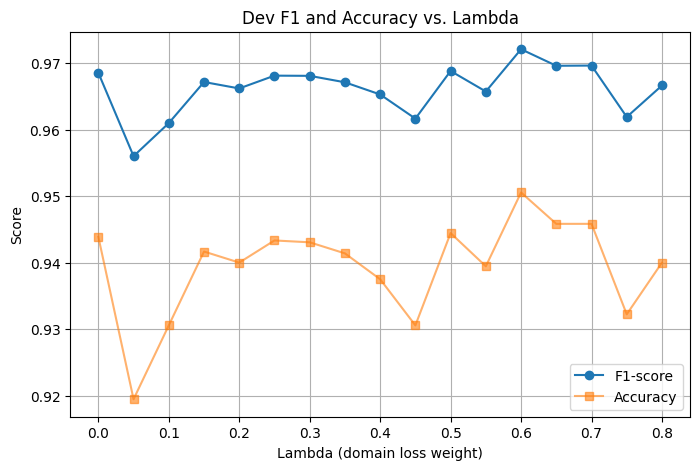

→ Re-train model with best lambda = 0.6 and run final prediction on test set


In [18]:
df_result = pd.read_csv("logs/experiment_summary.csv")

best_row = df_result.sort_values("mean_f1", ascending=False).iloc[0]

# get the printing information
best_lambda = best_row["lambda"]
best_f1 = best_row["mean_f1"]
best_acc = best_row["mean_acc"]

print(f"Best lambda based on dev F1: {best_lambda}")
print(f"  → Mean F1: {best_f1:.4f}, Mean Acc: {best_acc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_result["lambda"], df_result["mean_f1"], marker='o', label="F1-score")
plt.plot(df_result["lambda"], df_result["mean_acc"], marker='s', label="Accuracy", alpha=0.6)
plt.xlabel("Lambda (domain loss weight)")
plt.ylabel("Score")
plt.title("Dev F1 and Accuracy vs. Lambda")
plt.grid(True)
plt.legend()
plt.show()

print(f"→ Re-train model with best lambda = {best_lambda} and run final prediction on test set")

In [30]:

# retrain final model using best_lambda
model = DomainAwareTransformer()
final_model, _ = train_and_log(
    model,
    train_dataset,
    dev_dataset=dev_dataset,
    domain_loss_weight=best_lambda,
    run_id=999,
    patience=3,
    verbose=True
)

# predict final model
test_preds = predict(final_model, test_dataset)

[Run 999] Epoch 1: Loss=56.1929, Dev Acc=0.8750, F1=0.9333


[Run 999] Epoch 2: Loss=35.8876, Dev Acc=0.9225, F1=0.9572


[Run 999] Epoch 3: Loss=23.5926, Dev Acc=0.9400, F1=0.9656


[Run 999] Epoch 4: Loss=19.3231, Dev Acc=0.9192, F1=0.9556


[Run 999] Epoch 5: Loss=16.2747, Dev Acc=0.9400, F1=0.9664


[Run 999] Epoch 6: Loss=10.9930, Dev Acc=0.9250, F1=0.9588


[Run 999] Epoch 7: Loss=9.4893, Dev Acc=0.9483, F1=0.9707


[Run 999] Epoch 8: Loss=7.1130, Dev Acc=0.9500, F1=0.9719


[Run 999] Epoch 9: Loss=5.3923, Dev Acc=0.9467, F1=0.9701


[Run 999] Epoch 10: Loss=3.6173, Dev Acc=0.9525, F1=0.9729


In [31]:
# Save result to csv
df_test["prediction"] = test_preds

In [32]:
df_test.head()

,text,id,prediction
0,"[9159, 3048, 238, 276, 162, 286, 305, 22, 36, ...",0,0
1,"[64, 5039, 1275, 6, 0, 871, 139, 270, 327, 237...",1,0
2,"[327, 618, 76, 650, 121, 274, 1025, 0, 12207, ...",2,0
3,"[6, 12, 609, 11905, 4, 879, 677, 78, 13352, 60...",3,1
4,"[1, 5504, 55, 22, 101, 3783, 139, 2664, 4, 1, ...",4,1


In [35]:
# id, label -> output
df_test_final = df_test[["id", "prediction"]]
df_test_final.rename(columns={"prediction": "label"}, inplace=True)

df_test_final.to_csv("Test_Transformer_Domain_Aware.csv", index=False)
print("Test prediction saved to test_predictions_final.csv")

Test prediction saved to test_predictions_final.csv


<ipython-input-35-8f7443fc119d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_final.rename(columns={"prediction": "label"}, inplace=True)


In [36]:
from google.colab import files
files.download("Test_Transformer_Domain_Aware.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Output prediction
df_test['label'] = predictions

df_submission = df_test[['id', 'label']]

df_submission.to_csv("submission_trans_v2.csv", index=False)

print(df_submission.shape)          # (4000, 2)
print(df_submission.head())
print(df_submission['label'].value_counts())  # check distribution